# XGBoost Classifier Model

In [1]:
"""
Raw training script (no class balancing enabled).

To try a different class balancing method:
1. Comment out the “No class balancing” block below.
2. Uncomment the block for the method you want to use.

For the “scaled” method:
- Run the script as-is (no class balancing).
- Then uncomment the three `scale_pos_weight` parameters in the XGBoost model setup.
"""

'\nRaw training script (no class balancing enabled).\n\nTo try a different class balancing method:\n1. Comment out the “No class balancing” block below.\n2. Uncomment the block for the method you want to use.\n\nFor the “scaled” method:\n- Run the script as-is (no class balancing).\n- Then uncomment the three `scale_pos_weight` parameters in the XGBoost model setup.\n'

## General libs

In [2]:
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import uniform, randint
import pickle

import time
import datetime
from datetime import datetime, timedelta
import subprocess
import sys
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict

import joblib

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')


import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, average_precision_score, precision_recall_curve, precision_score, recall_score, f1_score

## Sources of Data and Initial Processing

In [3]:
df_orig = pd.read_pickle("./df_final_xCache.pkl")

le = LabelEncoder()

d_label = df_orig['d_label']
d_label_encoded = le.fit_transform(d_label)
df_orig['d_label_encoded'] = d_label_encoded

## Generation of periods

In [4]:
df_orig['date'].max()

'2024-04-30'

In [5]:
start_date = datetime(2023, 6, 1)

# Function to generate periods
def generate_periods(start_date, periods, days_per_period):
    result = []
    
    # Loop through the number of periods and create 15-day intervals
    for _ in range(periods):
        end_date = start_date + timedelta(days=days_per_period)
        # Convert to string with the format "%Y-%m-%d"
        period_str = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
        result.append(period_str)
        start_date = end_date  # Move the start date to the end date of the current period
    
    return result


periods = generate_periods(start_date, 47, 7)

p = periods[0][0]
m = periods[1][1]

train_p = []
fut_acc_p = []

for i in range(0,len(periods)-2):
    train_p.append([periods[i][0], periods[i+1][1]])
    fut_acc_p.append([periods[i+1][1], periods[i+2][1]])

print("We have", len(train_p), "realizations \n")
print("Train:", train_p, '\n')
print("Future Accesses:", fut_acc_p)

We have 45 realizations 

Train: [['2023-06-01', '2023-06-15'], ['2023-06-08', '2023-06-22'], ['2023-06-15', '2023-06-29'], ['2023-06-22', '2023-07-06'], ['2023-06-29', '2023-07-13'], ['2023-07-06', '2023-07-20'], ['2023-07-13', '2023-07-27'], ['2023-07-20', '2023-08-03'], ['2023-07-27', '2023-08-10'], ['2023-08-03', '2023-08-17'], ['2023-08-10', '2023-08-24'], ['2023-08-17', '2023-08-31'], ['2023-08-24', '2023-09-07'], ['2023-08-31', '2023-09-14'], ['2023-09-07', '2023-09-21'], ['2023-09-14', '2023-09-28'], ['2023-09-21', '2023-10-05'], ['2023-09-28', '2023-10-12'], ['2023-10-05', '2023-10-19'], ['2023-10-12', '2023-10-26'], ['2023-10-19', '2023-11-02'], ['2023-10-26', '2023-11-09'], ['2023-11-02', '2023-11-16'], ['2023-11-09', '2023-11-23'], ['2023-11-16', '2023-11-30'], ['2023-11-23', '2023-12-07'], ['2023-11-30', '2023-12-14'], ['2023-12-07', '2023-12-21'], ['2023-12-14', '2023-12-28'], ['2023-12-21', '2024-01-04'], ['2023-12-28', '2024-01-11'], ['2024-01-04', '2024-01-18'], ['2024

## Model Train

############  1
Train: ['2023-06-01', '2023-06-14']
Future Accesses: ['2023-06-15', '2023-06-22']



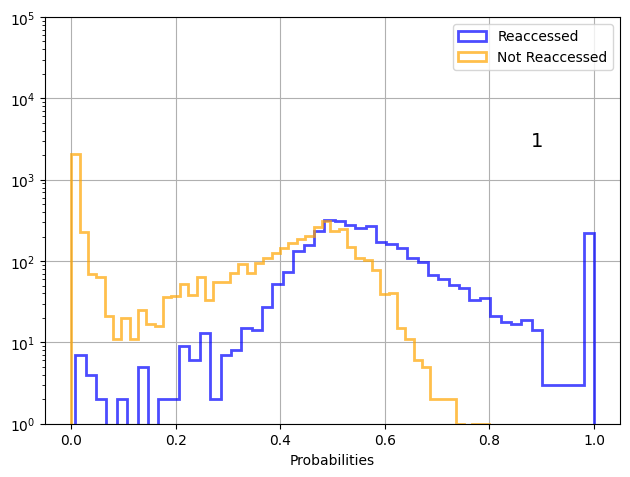

NameError: name 'o' is not defined

In [6]:
retrain = False
useFiles = False
createModel = True

rl_a = []

accesses_train = []
accesses_fut_acc = []

unique_files_train = []
unique_files_fut_acc = []

roc_curves = []
pr_curves = []

importances_by_period = {}


# directory to save XGBoost decision trees
path1 = f"./XGBoost/raw/trees/Decision_Tree_XGB"

# directory to save XGBoost results
path2 = f"./XGBoost/raw/results/Results_XGB"


gif_dir = os.path.join(path2, "gif")
results_txt = os.path.join(path2, "Results.txt")

os.makedirs(path1, exist_ok=True)
os.makedirs(gif_dir, exist_ok=True)

if os.path.exists(results_txt):
    os.remove(results_txt)
    
all_preds_by_o = []
all_labels_by_o = []

results = {
    "auc": [[], []],
    "acc": [[], []],
    "rec": [[], []],
    "prec": [[], []],
    "f1": [[], []]
}

f = open(f"{path2}/Results.txt", "a")

ii = 0

for rl in range(0,len(train_p)):
    ii+=1
    print("############ ", ii)
    rl_a.append(str(rl+1))

    # Sample generation

    df1 = df_orig[ (df_orig['date'] >= train_p[rl][0]) & (df_orig['date'] < train_p[rl][1])].copy()
    df2 = df_orig[ (df_orig['date'] >= fut_acc_p[rl][0]) & (df_orig['date'] < fut_acc_p[rl][1])].copy()

    accesses_train.append(df1.shape[0])
    accesses_fut_acc.append(df2.shape[0])
    unique_files_train.append(len(df1['filename'].unique()))
    unique_files_fut_acc.append(len(df2['filename'].unique()))
   
    # Add new column for the Accesses in the train    
    df1['Access'] = df1.groupby(['filename']).cumcount().add(1)
    df1['Total Accesses'] = df1.groupby('filename').filename.transform('count')
    
    # Add new column with the read access to period
    date_string = df2['date'].max() + " 23:59:59.999999"
    dt_object = datetime.strptime(date_string, "%Y-%m-%d %H:%M:%S.%f")
    epoch_time_period1 = dt_object.timestamp()
    df1['read_access time'] = (epoch_time_period1 - df1['time'])

    # Add new column for the Future Access in the train and test periods       
    df1['future_acc'] = df1.filename.isin(df2.filename).astype(int)  
    df1.sort_values(['filename','time'], ascending=[True,True], inplace = True)
            
    # Calculate the last 5 accesses
    df1["5th last read access"] = df1['read_access time'].shift(4)
    df1["4th last read access"] = df1['read_access time'].shift(3)
    df1["3rd last read access"] = df1['read_access time'].shift(2)
    df1["2nd last read access"] = df1['read_access time'].shift(1)
    df1["last read access"] = df1['read_access time']

    df1.loc[df1['Total Accesses'] == 1, '2nd last read access'] = np.nan
    df1.loc[df1['Total Accesses'] == 1, '3rd last read access'] = np.nan
    df1.loc[df1['Total Accesses'] == 1, '4th last read access'] = np.nan
    df1.loc[df1['Total Accesses'] == 1, '5th last read access'] = np.nan
        
    df1.loc[df1['Total Accesses'] == 2, '3rd last read access'] = np.nan
    df1.loc[df1['Total Accesses'] == 2, '4th last read access'] = np.nan
    df1.loc[df1['Total Accesses'] == 2, '5th last read access'] = np.nan
        
    df1.loc[df1['Total Accesses'] == 3, '4th last read access'] = np.nan
    df1.loc[df1['Total Accesses'] == 3, '5th last read access'] = np.nan
        
    df1.loc[df1['Total Accesses'] == 4, '5th last read access'] = np.nan
        
    # Calculate first accesses
    df1.sort_values(['filename','time'], ascending=[True,True], inplace = True)

    df1_first=df1.drop_duplicates(subset = ['filename'], keep = 'first', inplace = False)
    df1_last=df1.drop_duplicates(subset = ['filename'], keep = 'last', inplace = False)
    df1_first_list=list(df1_first["time"])
    df1_last_list=list(df1_last["time"])
        
    # DeltaT 1st access and most recent:
    dt_1st_to_last = [(x1 - x2) for (x1, x2) in zip(df1_last_list, df1_first_list)]
    dt_1st_to_last = [0 if x==0 else x for x in dt_1st_to_last]
        
    # Recency 1st access
    recency_1st = [(epoch_time_period1 - x) for x in df1_first_list]
        
    df1.sort_values(['filename','time'], ascending=[True,True], inplace = True)
    df1_final = df1.copy()
    df1_final.drop_duplicates(subset = ['filename'], keep = 'last', inplace = True)
    df1_final.sort_values(by='filename', ascending=True, inplace = True)
        
    df1_final.loc[:, 'deltaT_1_last'] = dt_1st_to_last
    df1_final.loc[:, 'recency_1st'] = recency_1st
    
    df1_final['future_acc'] = df1_final.pop('future_acc')

    
    if ii <=1:
        df1_final_cp = df1_final.copy()
    else:
        df1_final_cp = pd.concat([df1_final.copy(), df1_final_cp])

    
    threshold_time = pd.to_datetime(df1_final_cp['date'].max()) - pd.DateOffset(months=3)
    df1_final_cp = df1_final_cp[df1_final_cp['date'] >= threshold_time.strftime("%Y-%m-%d")]
    df1_final_cp = df1_final_cp[df1_final_cp['date'] >= threshold_time.strftime("%Y-%m-%d")]
    

    df1_final_c = df1_final_cp.copy()
    
    f_test=0.3
    
    df1_final_c.sort_values(by='time', ascending=True, inplace=True)
    

    ##########################
    # Undersampling
    # df1_final_var = df1_final_c.drop(columns=['future_acc']).copy()
    # df1_final_label = df1_final_c['future_acc']

    # under = RandomUnderSampler(sampling_strategy=1)
    # df1_final_var_under, df1_final_label_under = under.fit_resample(df1_final_var, df1_final_label)

    # df1_final_under = pd.concat([df1_final_var_under, df1_final_label_under], axis=1)

    # string_train_date = f"Train: ['{df1_final_under['date'].min()}', '{df1_final_under['date'].max()}']"
    # string_fut_date = f"Future Accesses: {str(fut_acc_p[rl])}\n"

    # print(f"Train: ['{df1_final_under['date'].min()}', '{df1_final_under['date'].max()}']")
    # print(f"Future Accesses: {str(fut_acc_p[rl])}\n")

    # df1_final = df1_final_under.copy()

    
    ##########################
    # Tomek links

    # df1_final_label = df1_final_c['future_acc']

    # df1_final_var = df1_final_c.select_dtypes(include=['number'])
    # df1_final_var = df1_final_var.drop(columns=['future_acc'])
    
    # df1_final_var = df1_final_var.fillna(-1.0)
    
    # tl = TomekLinks(sampling_strategy='auto')
    # df1_final_var_under, df1_final_label_under = tl.fit_resample(df1_final_var, df1_final_label)

    # df1_final_under = pd.concat([df1_final_var_under, df1_final_label_under], axis=1)

    # df1_final_under = df1_final_under.replace(-1.0, np.nan)

    # df1_final = df1_final_under.copy()


    ##########################
    # Edited Nearest Neighbours

    # df1_final_label = df1_final_c['future_acc']

    # df1_final_var = df1_final_c.select_dtypes(include=['number'])
    # df1_final_var = df1_final_var.drop(columns=['future_acc'])
    
    # df1_final_var = df1_final_var.fillna(-1.0)
    
    # enn = EditedNearestNeighbours(sampling_strategy='auto')
    # df1_final_var_under, df1_final_label_under = enn.fit_resample(df1_final_var, df1_final_label)

    # df1_final_under = pd.concat([df1_final_var_under, df1_final_label_under], axis=1)

    # df1_final_under = df1_final_under.replace(-1.0, np.nan)

    # df1_final = df1_final_under.copy()

    ##########################
    #SMOTE
    # string_train_date = f"Train: ['{df1_final_c['date'].min()}', '{df1_final_c['date'].max()}']"
    # string_fut_date = f"Future Accesses: {str(fut_acc_p[rl])}\n"

    # print(f"Train: ['{df1_final_c['date'].min()}', '{df1_final_c['date'].max()}']")
    # print(f"Future Accesses: {str(fut_acc_p[rl])}\n")

    # df1_final_c = df1_final_c.sample(frac = 1).copy()

    # df1_final_c = df1_final_c.fillna(-1.0)
    
    # df1_final_var = df1_final_c.drop(columns=['future_acc']).copy()
    # df1_final_label = df1_final_c['future_acc']
    
    # df1_final_var_numeric = df1_final_var.select_dtypes(include=['number'])

    # smote = SMOTE(sampling_strategy=1)
    # df1_final_var_resampled, df1_final_label_resampled = smote.fit_resample(df1_final_var_numeric, df1_final_label)

    # df1_final_resampled = pd.concat([df1_final_var_resampled, df1_final_label_resampled], axis=1)

    # df1_final_resampled['future_acc'] = df1_final_resampled['future_acc'].astype(int)

    # df1_final_resampled = df1_final_resampled.replace(-1.0, np.nan)
    
    # df1_final = df1_final_resampled.copy()

    ##########################
    #SMOTEEN
    # string_train_date = f"Train: ['{df1_final_c['date'].min()}', '{df1_final_c['date'].max()}']"
    # string_fut_date = f"Future Accesses: {str(fut_acc_p[rl])}\n"

    # print(f"Train: ['{df1_final_c['date'].min()}', '{df1_final_c['date'].max()}']")
    # print(f"Future Accesses: {str(fut_acc_p[rl])}\n")

    # df1_final = df1_final_c.sample(frac = 1).copy()

    # df1_final_c = df1_final_c.fillna(-1.0)
    
    # df1_final_var = df1_final_c.drop(columns=['future_acc']).copy()
    # df1_final_label = df1_final_c['future_acc']
    
    # df1_final_var_numeric = df1_final_var.select_dtypes(include=['number'])

    # smoteenn = SMOTEENN(sampling_strategy=1)
    # df1_final_var_resampled, df1_final_label_resampled = smoteenn.fit_resample(df1_final_var_numeric, df1_final_label)

    # df1_final_resampled = pd.concat([df1_final_var_resampled, df1_final_label_resampled], axis=1)

    # df1_final_resampled['future_acc'] = df1_final_resampled['future_acc'].astype(int)

    # df1_final_resampled = df1_final_resampled.replace(-1.0, np.nan)

    # df1_final = df1_final_resampled.copy()

    ##########################
    #SMOTE TOMEK
    # string_train_date = f"Train: ['{df1_final_c['date'].min()}', '{df1_final_c['date'].max()}']"
    # string_fut_date = f"Future Accesses: {str(fut_acc_p[rl])}\n"

    # print(f"Train: ['{df1_final_c['date'].min()}', '{df1_final_c['date'].max()}']")
    # print(f"Future Accesses: {str(fut_acc_p[rl])}\n")

    # df1_final = df1_final_c.sample(frac = 1).copy()

    # df1_final_c = df1_final_c.fillna(-1.0)
    
    # df1_final_var = df1_final_c.drop(columns=['future_acc']).copy()
    # df1_final_label = df1_final_c['future_acc']
    
    # df1_final_var_numeric = df1_final_var.select_dtypes(include=['number'])

    # smtk = SMOTETomek(sampling_strategy=1)
    # df1_final_var_resampled, df1_final_label_resampled = smtk.fit_resample(df1_final_var_numeric, df1_final_label)

    # df1_final_resampled = pd.concat([df1_final_var_resampled, df1_final_label_resampled], axis=1)

    # df1_final_resampled['future_acc'] = df1_final_resampled['future_acc'].astype(int)

    # df1_final_resampled = df1_final_resampled.replace(-1.0, np.nan)

    # df1_final = df1_final_resampled.copy()
    
    
    ##########################
    # No class balance

    string_train_date = f"Train: ['{df1_final_c['date'].min()}', '{df1_final_c['date'].max()}']"
    string_fut_date = f"Future Accesses: {str(fut_acc_p[rl])}\n"

    print(f"Train: ['{df1_final_c['date'].min()}', '{df1_final_c['date'].max()}']")
    print(f"Future Accesses: {str(fut_acc_p[rl])}\n")

    df1_final = df1_final_c.sample(frac = 1).copy()

    
    ##########################
    # End of class balance methods



    # -----Continuation-----
    # Apply a logarithmic transformation to the required columns

    log_vars =  ['Total Accesses', '5th last read access', '4th last read access',
                 '3rd last read access', '2nd last read access','last read access',
                'recency_1st', 'deltaT_1_last']

    for var in log_vars:
        df1_final[var] = np.log1p(df1_final[var])
        
    

    thevars = ['last read access','recency_1st', 'deltaT_1_last', '2nd last read access',
               '3rd last read access', '4th last read access','5th last read access', 
               'Total Accesses', 'd_label_encoded', 'future_acc']

    
    df1_final['future_acc'] = df1_final['future_acc'].astype(int)
    
    df1_final = df1_final[thevars]


    # Nested Cross Validation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True)
    
    all_best_params = []

    auc_scores, acc_scores, rec_scores, prec_scores, f1_scores = [], [], [], [], []
    
    for outer_fold, (train_val_idx, test_idx) in enumerate(outer_cv.split(df1_final.drop(columns=['future_acc']), df1_final['future_acc'])):
    
        df1_train_val = df1_final.iloc[train_val_idx]
        df1_test = df1_final.iloc[test_idx]

        train_valL = df1_train_val['future_acc'].values
        testL = df1_test['future_acc'].values
    
        train_valD = df1_train_val.drop(columns=['future_acc']).values
        testD = df1_test.drop(columns=['future_acc']).values
    

        sss = StratifiedShuffleSplit(n_splits=1, test_size=f_test)
        for train_index, val_index in sss.split(train_valD, train_valL):
            trainD, valD = train_valD[train_index], train_valD[val_index]
            trainL, valL = train_valL[train_index], train_valL[val_index]
    
        # Calculate scale_pos_weight to handle class imbalance within the fold
        scale = len(trainL[trainL == 0]) / len(trainL[trainL == 1])

        
        param_dist = {
            'n_estimators': randint(100, 400),
            'max_depth': randint(3, 10),
            'learning_rate': uniform(0.01, 0.3),
            'subsample': uniform(0.7, 0.3),
            'colsample_bytree': uniform(0.7, 0.3),
            'reg_lambda': uniform(0, 2),
            'reg_alpha': uniform(0, 1)
        }
    
        model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            tree_method='gpu_hist',
            predictor='gpu_predictor',
            # scale_pos_weight=scale
        )

        inner_cv = StratifiedKFold(n_splits=3, shuffle=True)
    
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=20,
            cv=inner_cv,
            n_jobs=1,
            scoring='roc_auc',
            verbose=0
        )
    
        random_search.fit(trainD, trainL)
    
        best_params = random_search.best_params_
        all_best_params.append(best_params)
    
        dtrain = xgb.DMatrix(trainD, label=trainL)
        dval = xgb.DMatrix(valD, label=valL)
    
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'tree_method': 'hist',
            'device': 'cuda',
            # 'scale_pos_weight': scale,
            **best_params
        }
    
        model_fold = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=1000,
            evals=[(dval, 'val')],
            early_stopping_rounds=10,
            verbose_eval=False,
        )
    
        dtest = xgb.DMatrix(testD)
        pred_proba = model_fold.predict(dtest)

        pred_labels = (pred_proba > 0.5).astype(int)
        
        auc_score = roc_auc_score(testL, pred_proba)
        acc = accuracy_score(testL, pred_labels)
        rec = recall_score(testL, pred_labels)
        prec = precision_score(testL, pred_labels)
        f1 = f1_score(testL, pred_labels)
    
        # print(f"AUC Fold {outer_fold+1}: {auc_score:.4f}")
        
        auc_scores.append(auc_score)
        acc_scores.append(acc)
        rec_scores.append(rec)
        prec_scores.append(prec)
        f1_scores.append(f1)
        
    
    results["auc"][0].append(np.mean(auc_scores))
    results["auc"][1].append(np.std(auc_scores, ddof = 1)/np.sqrt(len(auc_scores)))
    
    results["acc"][0].append(np.mean(acc_scores))
    results["acc"][1].append(np.std(acc_scores, ddof = 1)/np.sqrt(len(acc_scores)))
    
    results["rec"][0].append(np.mean(rec_scores))
    results["rec"][1].append(np.std(rec_scores, ddof = 1)/np.sqrt(len(rec_scores)))
    
    results["prec"][0].append(np.mean(prec_scores))
    results["prec"][1].append(np.std(prec_scores, ddof = 1)/np.sqrt(len(prec_scores)))
    
    results["f1"][0].append(np.mean(f1_scores))
    results["f1"][1].append(np.std(f1_scores, ddof = 1)/np.sqrt(len(f1_scores)))
    
    # print(f"Mean AUC (Nested CV): {mean_auc:.4f} ± {std_auc:.4f}")

    param_sums = defaultdict(float)
    
    for bp in all_best_params:
        for key, value in bp.items():
            param_sums[key] += value
    
    int_params = ['n_estimators', 'max_depth']

    best_params_avg = {}
    for key in param_sums:
        mean_value = param_sums[key] / len(all_best_params)
        if key in int_params:
            best_params_avg[key] = int(round(mean_value))
        else:
            best_params_avg[key] = float(mean_value)
    
    # print("Best_params average:", best_params_avg)

    dtrain_final = xgb.DMatrix(df1_final.drop(columns=['future_acc']).values, label=df1_final['future_acc'].values)
    
    scale = len(trainL[trainL == 0]) / len(trainL[trainL == 1])

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',
        'device': 'cuda',
        # 'scale_pos_weight': scale,
        **best_params_avg
    }
    

    model_final = xgb.train(
        params=params,
        dtrain=dtrain_final,
        num_boost_round=1000,
        evals=[(dtrain_final, 'train')],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    

    model_final.save_model(f'{path1}/model_xgb_{int(epoch_time_period1)}.ubj')
    
    dtest = xgb.DMatrix(testD)
    pred_proba = model_final.predict(dtest)  
    pred_labels = (pred_proba > 0.5).astype(int)

    
    ###############
    #Predicted probability distribution by period
    pred_probs_reaccessed = pred_proba[testL  == 1]  
    pred_probs_non_reaccessed = pred_proba[testL  == 0] 
    
    plt.hist(pred_probs_reaccessed, bins=50, color='blue', alpha=0.7, label='Reaccessed', histtype='step', linewidth=2)
    plt.hist(pred_probs_non_reaccessed, bins=50, color='orange', alpha=0.7, label='Not Reaccessed', histtype='step', linewidth=2)
    plt.yscale('log')
    plt.xlabel('Probabilities')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.ylim(1, 100000)
    plt.text(0.88, 2300, ii , fontsize=14, ha='left', va='bottom')
    plt.savefig(f"{path2}/gif/hist_gif{ii}.png", dpi=300)
    plt.show()

    all_preds_by_o[o].append(pred_proba)
    all_labels_by_o[o].append(testL)

    accuracy = accuracy_score(testL, pred_labels)
    recall = recall_score(testL, pred_labels)
    precision = precision_score(testL, pred_labels)
    f1 = f1_score(testL, pred_labels)
    auc_a = roc_auc_score(testL, pred_proba)

    print(f"\n--- Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc_a:.4f}\n")

    importances_by_period[o] = []

    feature_names = df1_final.drop(columns=['future_acc']).columns.tolist()

    importance_dict = model_final.get_score(importance_type='weight')

    mapped_importance = {
        feature_names[int(k[1:])]: v for k, v in importance_dict.items()
        if k.startswith('f') and k[1:].isdigit() and int(k[1:]) < len(feature_names)
    }

    importances_by_period[o].append(mapped_importance)

    
    
###############
#Output results
str_to_file = (
    f"{','.join(map(str, results['auc'][0]))}\n"
    f"{','.join(map(str, results['auc'][1]))}\n"
    f"{','.join(map(str, results['acc'][0]))}\n"
    f"{','.join(map(str, results['acc'][1]))}\n"
    f"{','.join(map(str, results['rec'][0]))}\n"
    f"{','.join(map(str, results['rec'][1]))}\n"
    f"{','.join(map(str, results['prec'][0]))}\n"
    f"{','.join(map(str, results['prec'][1]))}\n"
    f"{','.join(map(str, results['f1'][0]))}\n"
    f"{','.join(map(str, results['f1'][1]))}\n"
)

with open(f"{path2}/Results.txt", "a") as f:
    f.write(str_to_file)
        

all_preds_flat = np.concatenate(all_preds_by_o[o])
all_labels_flat = np.concatenate(all_labels_by_o[o])

overall_auc = roc_auc_score(all_labels_flat, all_preds_flat)

fpr, tpr, _ = roc_curve(all_labels_flat, all_preds_flat)
roc_auc = auc(fpr, tpr)

roc_curves.append((fpr, tpr, roc_auc, o))

precision, recall, _ = precision_recall_curve(all_labels_flat, all_preds_flat)
ap = average_precision_score(all_labels_flat, all_preds_flat)
pr_curves.append((recall, precision, ap, o))


###############
#Total redicted probability distribution
pred_probs_reaccessed = all_preds_flat[all_labels_flat  == 1]  
pred_probs_non_reaccessed = all_preds_flat[all_labels_flat  == 0] 

plt.hist(pred_probs_reaccessed, bins=50, color='blue', alpha=0.7, label='Reaccessed', histtype='step', linewidth=2)
plt.hist(pred_probs_non_reaccessed, bins=50, color='orange', alpha=0.7, label='Not reaccessed', histtype='step', linewidth=2)
plt.yscale('log')
plt.xlabel('Probabilities')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{path2}/hist_probabilities.png", dpi=300)
plt.show()

    
###############
#Confusion matrix
all_pred_labels = (all_preds_flat > 0.5).astype(int)

class_names = ['Not reaccessed', 'Reaccessed']

cm = confusion_matrix(all_labels_flat, all_pred_labels)

cm_percent = cm.astype('float') / cm.sum(axis=0, keepdims=True) * 100

plt.imshow(cm_percent, interpolation='nearest', cmap='Blues')
plt.colorbar(label='% of prediction')

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

labels = np.array([['TN', 'FP'], ['FN', 'TP']])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        pct = cm_percent[i, j]
        plt.text(j, i, f"{labels[i, j]} = {pct:.1f}%", 
                 ha="center", va="center",
                 color="white" if pct > cm_percent.max()/2 else "black")

plt.ylabel('True label')
plt.xlabel('Prediction label')
plt.tight_layout()
plt.savefig(f"{path2}/confusion_matrix.png", dpi=300)
plt.show()


###############
#Feature Importance
average_importance = defaultdict(float)
count_importance = defaultdict(int)

for imp in importances_by_period[o]:
    for feat, val in imp.items():
        average_importance[feat] += val
        count_importance[feat] += 1

for feat in average_importance:
    average_importance[feat] /= count_importance[feat]

importance_df = pd.DataFrame(
    list(average_importance.items()), columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=True)

plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Average Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{path2}/feature_importance.png", dpi=300)
plt.show()


###############
#Correlation matrix
feature_columns = df1_final.drop(columns=['future_acc']).columns

corr_matrix = df1_final[feature_columns].corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis', square=True, cbar_kws={"shrink": .8})
plt.tight_layout()
plt.savefig(f"{path2}/correlation_matrix.png", dpi=300)
plt.show()


###############
#Precision-Recall
for recall, precision, ap, o in pr_curves:
    plt.plot(recall, precision, lw=1.5, label=f'AP = {ap:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig(f"{path2}/corves_precision_recall.png", dpi=300)
plt.show()

with open(f"{path2}/pr_curves_data.pkl", "wb") as f:
    pickle.dump(pr_curves, f)

###############
#ROC Curves
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=1)
for fpr, tpr, roc_auc, o in roc_curves:
    plt.plot(fpr, tpr, lw=1.5, label=f'AUC = {roc_auc:.4f}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.savefig(f"{path2}/corves_roc.png", dpi=300)   
plt.show()

with open(f"{path2}/roc_curves_data.pkl", "wb") as f:
    pickle.dump(roc_curves, f)
        